# 1. Preparación de entorno. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from pmdarima import auto_arima
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

Note: you may need to restart the kernel to use updated packages.


# 2. Carga de datos. 

In [2]:
# Load the lake hydrology data
df_rivers = pd.read_csv("../data/processed/rivers/river_hydrology_data_clean.csv")
df_rivers.head()

,Date,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
0,1998-01-01,1,0.0,0.0,1.82
1,1998-01-02,1,0.0,0.0,1.94
2,1998-01-03,1,0.0,0.0,2.11
3,1998-01-04,1,0.0,0.0,1.84
4,1998-01-05,1,0.0,0.0,1.88


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [3]:
df_rivers["Date"] = pd.to_datetime(df_rivers["Date"])

In [4]:
df_rivers.set_index("Date", inplace=True)

In [5]:
df_rivers.sort_index(inplace=True)

In [6]:
df_monthly = df_rivers.resample('M').mean() 

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_30526/1901548509.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_rivers.resample('M').mean()


In [7]:
df_monthly.head()

,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
Date,,,,
1998-01-31,7.5,0.0,0.0,1.862903
1998-02-28,7.5,0.0,0.0,1.691786
1998-03-31,7.5,0.0,0.0,1.682258
1998-04-30,7.5,0.0,0.0,2.198000
1998-05-31,7.5,0.0,0.0,1.718710


In [8]:
df = df_monthly

In [9]:
# Dividir los datos en entrenamiento y prueba
n_obs = 50 # Número de observaciones para predecir
train_df = df[:-n_obs]
test_df = df[-n_obs:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 220
Tamaño del conjunto de prueba: 50


In [10]:
train_df.describe()

,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
count,220.0,220.000000,220.000000,220.000000
mean,7.5,1.258360,14.066805,1.466045
std,0.0,1.412916,8.471927,0.499600
min,7.5,0.000000,0.000000,0.000000
25%,7.5,0.000000,8.115078,1.129194
50%,7.5,0.858879,13.790215,1.348333
75%,7.5,2.097749,21.529731,1.778476
max,7.5,7.730476,31.817742,2.883214


In [11]:
train_df.drop(columns=['Rainfall_Location'], inplace=True)

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_30526/1485641800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['Rainfall_Location'], inplace=True)


In [12]:
# Crear y ajustar el modelo VAR
model = VAR(train_df)

# Encontrar el orden óptimo del modelo (p)
# statsmodels puede sugerir el orden basándose en criterios como AIC, BIC, etc.
# Aquí usamos un orden fijo por simplicidad, pero se recomienda optimizarlo.
results = model.fit(maxlags=2, ic='aic') # Probar hasta 2 retardos y usar AIC para la selección

print("Resumen del modelo ajustado:")
print(results.summary())

# Realizar la predicción
lag_order = results.k_ar
print(f"Orden de retardo (lags) del modelo: {lag_order}")

# Obtener los datos más recientes para la predicción
input_data = train_df.values[-lag_order:]

# Predecir el siguiente punto de datos
forecast = results.forecast(y=input_data, steps=n_obs)

# Lista de columnas que se usaron para el entrenamiento
var_columns = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']

# # Convertir la predicción a DataFrame
# # Usamos la lista de columnas 'var_columns' en lugar de df.columns
forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=var_columns)

print("\nPredicciones del modelo:")
print(forecast)
print("\nValores reales:")
print(test_df)
# Convertir la predicción a DataFrame para facilitar la visualización
#forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=df.columns)

# print("\nPredicciones del modelo:")
# print(forecast_df)
# print("\nValores reales:")
# print(test_df)

Resumen del modelo ajustado:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Aug, 2025
Time:                     21:11:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.400170
Nobs:                     218.000    HQIC:                  0.205829
Log likelihood:          -915.067    FPE:                    1.07703
AIC:                    0.0741411    Det(Omega_mle):        0.979602
--------------------------------------------------------------------
Results for equation Rainfall_Value
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        1.082329         0.372459            2.906           0.004
L1.Rainfall_Value            0.561794         0.075907            7.401           

In [13]:
test_df.head()

,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
Date,,,,
2016-05-31,7.5,1.483410,19.550000,1.675161
2016-06-30,7.5,0.780476,25.373333,1.463333
2016-07-31,7.5,0.322120,23.375806,1.090323
2016-08-31,7.5,0.088940,26.933871,1.084194
2016-09-30,7.5,1.212381,22.526667,1.119667


In [14]:
df.head()

,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
Date,,,,
1998-01-31,7.5,0.0,0.0,1.862903
1998-02-28,7.5,0.0,0.0,1.691786
1998-03-31,7.5,0.0,0.0,1.682258
1998-04-30,7.5,0.0,0.0,2.198000
1998-05-31,7.5,0.0,0.0,1.718710


In [15]:
#var_columns_all = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']

# Seleccionar solo las columnas relevantes del DataFrame original
df_plot = df[['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']]


            Rainfall_Value  Temperature_Value  Hydrometry_Value
Date                                                           
2016-05-31        0.630226          20.868695          1.268857
2016-06-30        0.806908          21.761575          1.191918
2016-07-31        1.079269          20.834397          1.200547
2016-08-31        1.330729          18.980791          1.259911
2016-09-30        1.509301          16.945996          1.337872
2016-10-31        1.598338          15.225485          1.410941
2016-11-30        1.608564          14.055861          1.465530
2016-12-31        1.564445          13.465525          1.497204
2017-01-31        1.493441          13.349287          1.508099
2017-02-28        1.418782          13.542527          1.503942
2017-03-31        1.355995          13.879248          1.491449
2017-04-30        1.312461          14.227929          1.476512
2017-05-31        1.288897          14.506146          1.463266
2017-06-30        1.281719          14.6

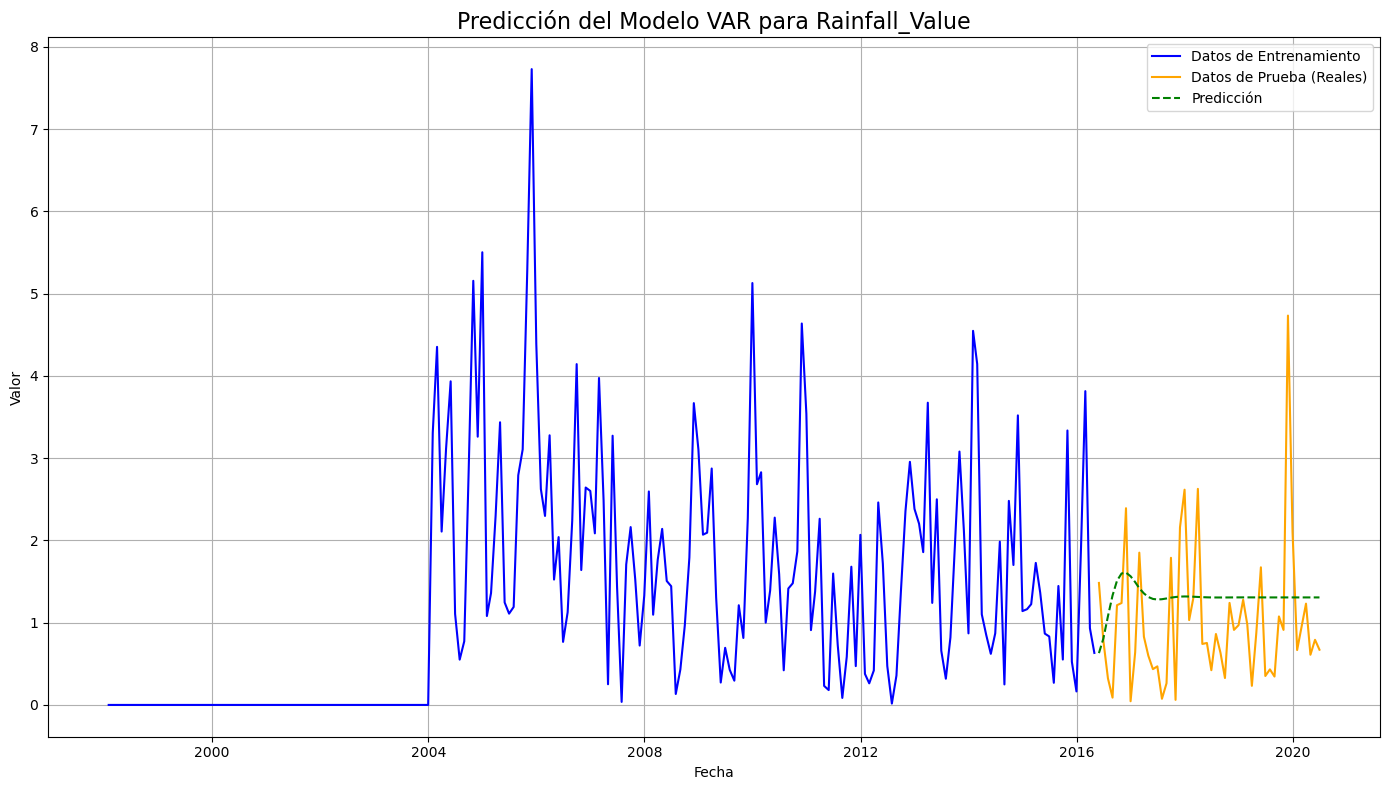

            Rainfall_Value  Temperature_Value  Hydrometry_Value
Date                                                           
2016-05-31        0.630226          20.868695          1.268857
2016-06-30        0.806908          21.761575          1.191918
2016-07-31        1.079269          20.834397          1.200547
2016-08-31        1.330729          18.980791          1.259911
2016-09-30        1.509301          16.945996          1.337872
2016-10-31        1.598338          15.225485          1.410941
2016-11-30        1.608564          14.055861          1.465530
2016-12-31        1.564445          13.465525          1.497204
2017-01-31        1.493441          13.349287          1.508099
2017-02-28        1.418782          13.542527          1.503942
2017-03-31        1.355995          13.879248          1.491449
2017-04-30        1.312461          14.227929          1.476512
2017-05-31        1.288897          14.506146          1.463266
2017-06-30        1.281719          14.6

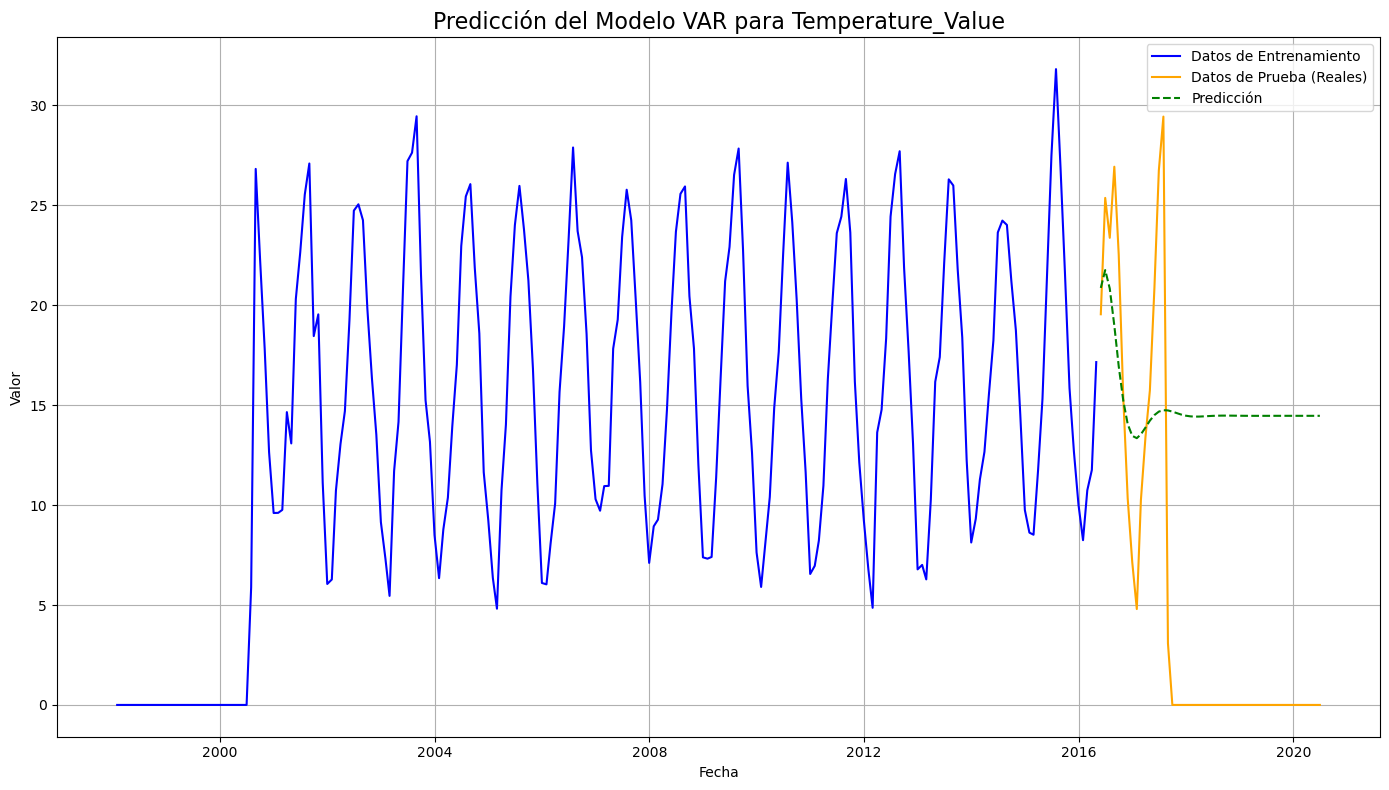

            Rainfall_Value  Temperature_Value  Hydrometry_Value
Date                                                           
2016-05-31        0.630226          20.868695          1.268857
2016-06-30        0.806908          21.761575          1.191918
2016-07-31        1.079269          20.834397          1.200547
2016-08-31        1.330729          18.980791          1.259911
2016-09-30        1.509301          16.945996          1.337872
2016-10-31        1.598338          15.225485          1.410941
2016-11-30        1.608564          14.055861          1.465530
2016-12-31        1.564445          13.465525          1.497204
2017-01-31        1.493441          13.349287          1.508099
2017-02-28        1.418782          13.542527          1.503942
2017-03-31        1.355995          13.879248          1.491449
2017-04-30        1.312461          14.227929          1.476512
2017-05-31        1.288897          14.506146          1.463266
2017-06-30        1.281719          14.6

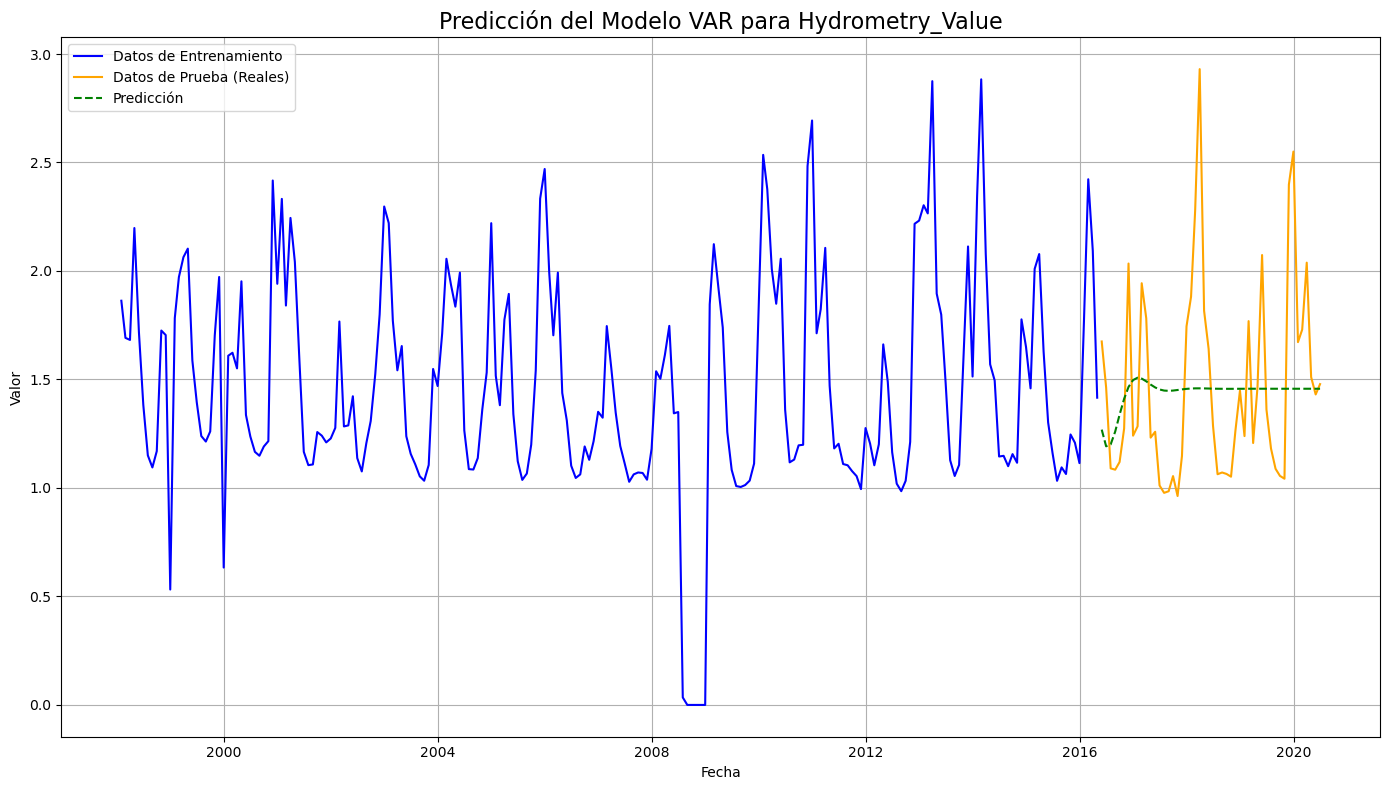

In [16]:
import matplotlib.pyplot as plt

# Lista de columnas que se usaron para el entrenamiento y la predicción
var_columns_all = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']

# # Seleccionar solo las columnas relevantes del DataFrame original
# df_plot = df[var_columns_all]

# Dividir los datos nuevamente, pero esta vez del DataFrame filtrado
train_df = df_plot[:-n_obs]
test_df = df_plot[-n_obs:]

# Tu código de entrenamiento y predicción iría aquí (el que ya está corregido)

# Combinar los DataFrames para una visualización completa
all_data = pd.concat([train_df, test_df])
forecast_all = pd.concat([train_df.iloc[-lag_order:], forecast_df])



# Crear el gráfico para cada una de las variables
for column in var_columns_all:
    plt.figure(figsize=(14, 8))
    
    # 1. Graficar los datos de entrenamiento
    sns.lineplot(data=train_df[column], label='Datos de Entrenamiento', color='blue')
    
    # 2. Graficar los datos reales del conjunto de prueba
    sns.lineplot(data=test_df[column], label='Datos de Prueba (Reales)', color='orange')
    
    print(forecast_df)
    # 3. Graficar la predicción
    # forecast_df ya tiene los índices de fecha correctos para la predicción
    sns.lineplot(data=forecast_df[column], label='Predicción', color='green', linestyle='--')
    
    # Opcional: sombrear el área de la predicción
    # Si quisieras intervalos de confianza para VAR, tendrías que calcularlos con `results.forecast_interval()`
    # y plotearlos de manera similar a como lo harías con un modelo ARIMA.
    
    # Título y etiquetas del gráfico
    plt.title(f'Predicción del Modelo VAR para {column}', fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    